In the previous post, we have classified the MNIST dataset using softmax regression. We got nearly 90% accuracy for both training and testing data which is very bad for production. In this notebook, let's build a deeper neural network and see if it can helps improving the classification accuracy. Specifically we will build a L layer neural network with L-1 hidden layers.

Let's first do some preprocessing and prepare our data,

Number of training examples = 31500
Number of testing examples = 10500
Number of features = 784


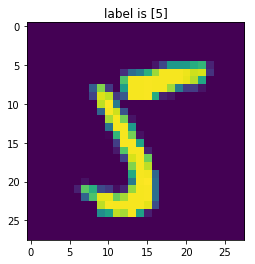

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

data = pd.read_csv("data/MNIST_train.csv").values

X_data = data[:, 1:]
Y_data = data[:, [0]]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state = 0)

print("Number of training examples = " + str(X_train.shape[0]) )
print("Number of testing examples = " + str(X_test.shape[0]) )
print("Number of features = " +  str(X_train.shape[1]) )

index = 10
sampleImg = np.reshape(X_train[index, :], [28, 28])

ax = plt.imshow(sampleImg)
plt.title("label is " + str(Y_train[index, :]))

X_train = X_train / 255
X_test = X_test / 255

In [3]:
def one_hot_matrix(Y, num_class):
    """
    Convert an array of Y to its one_hot_matrix
    
    Arguments:
    Y -- array (number of examples, 1)
    num_class -- num of classes
    
    Return:
    Y_one_hot -- (number of examples, num_class)
    """
    Y_one_hot = np.zeros((Y.shape[0], num_class))
    Y_one_hot[np.arange(Y.shape[0]), Y.T] = 1
    
    return Y_one_hot

In [4]:
Y_train_one_hot = one_hot_matrix(Y_train, 10)
Y_test_one_hot = one_hot_matrix(Y_test, 10)

index = 2
print("Letter " + str(Y_train[index, 0]) + " converted to " + str(Y_train_one_hot[index, :]))

Letter 9 converted to [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## 1. Initialize parameters
Our model structure is [LINEAR -> RELU] X (L-1) -> LINEAR -> SOFTMAX, i.e., it has L-1 hidden layers using a ReLU activation function followed by an output layer with a softmax activation function.

We will store $n^{[l]}$, the number of units in different layers, in a variable layer_dims. For example, layer_dims = $[1000, 100, 10]$ means we have $1000$ input features, one hidden layer with $100$ units and an output layer with $10$ units. Thus, the shape of $W_1$ is $(1000, 100)$, $b_1$ is $(1, 100)$, $W_2$ is $(100, 10)$, and $b_2$ is $(1, 10)$.

In [5]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python list containing the dimensions of each layer in our network.
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ... , "WL", "bL"
                  Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                  bl -- bias matrix of shape (1, layer_dims[l])
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)        # number of layers + 1
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((1, layer_dims[l]))
        
    return parameters

## 2. Forward propagation

In [13]:
def linear_forward(A, W, b):
    """
    Arguments:
    A -- activations from previous layer (or input data): (num of examples, size of previous layer)
    W -- weight matrix (size of previous layer, size of current layer)
    b -- bias vector (1, size of current layer)
    
    Return: 
    Z -- (num of examples, size of current layer)
    """
    
    Z = np.dot(A, W) + b
    cache = (A, W, b)
    
    assert(Z.shape == (X.shape[0], W.shape[1]) )
    
    return Z, cache

In [14]:
def soft_max(Z):
    """
    Arguments:
    Z -- (num of examples, size of current layer (or number of classes))
    
    Return:
    A -- softmax matrix (m, size of current layer (or number of classes)) 
    """
    exp_Z = np.exp(Z)
    A = exp_Z / exp_Z.sum(axis = 1, keepdims = True) # sum along columns
    
    assert(A.shape == Z.shape )
    
    return A

In [24]:
def relu(Z):
    """
    Arguments:
    Z -- (num of examples, size of current layer)
    
    Return:
    A -- relu: 0 for Z < 0 or Z for Z >=0
    """
    A = Z
    
    return A, 

In [25]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR -> ACTIVATION layer
    
    Arguments:
    A_prev -- activations from previous layer (or input data): (num of examples, size of previous layer)
    W -- weight matrix of current layer: (size of previous layer, size of current layer)
    b -- bias matrix: (1, size of current layer)
    activation -- "relu" or "softmax"
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "relu":    
        A = relu(Z)
    elif activation == "softmax":
        A = softmax(Z)
        
    assert(A.shape == (A.prev.shape[0], W.shape[1]))
    cache = linear_cache, Z
    
    return A, cache

In [16]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for ([LINEAR]->RELU)*(L-1) -> LINEAR -> softmax
    
    Argument:
    X -- input data matrix (num of examples, num of features)
    parameters -- output of initialize_parameters()
    
    Return:
    AL -- last post-activation value
    caches -- caches for (L - 1) layers
    """
    
    caches = []
    A = X
    L = len(parameters) // 2      # number of layers
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)
    
    assert(AL.shape[0] == X.shape[0])
    
    return AL, caches

In [17]:
def compute_cross_entropy_loss(A, Y):
    """
    Arguments:
    A -- prediction matrix of shape   (num of examples, num of class)
    Y -- one-hot matrix of true class (num of examples, num of class)
    Return:
    lost (scalar)
    """
    m = A.shape[0]
    return -(Y * np.log(A)).sum() / m

## 2. Backward propagation

### 2.1 - Linear backward

For layer $l$, the linear part is: $Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}$ (followed by an activation).

Suppose you have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. We want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

For one training example and unit $j$, we have $z_j = \sum\limits_{i = 1}^{size of previous layer} a_i w_{i, j} + b_j$, then,

$$dw_{i, j} = dz_j \frac{\partial z_j}{\partial dw_{i, j}} = dz_j * a_i $$
$$db_j = dz_j \frac{\partial z_j}{\partial db_j} = dz_j $$
$$da_i = dz_j w_{i, j} $$

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$:
$$ dW^{[l]} =  \frac{1}{m} A^{[l-1]} dZ^{[l]T}  $$
$$ db^{[l]} = \frac{1}{m} \ dZ^{[l]}.sum(axis = 0) $$
$$ dA^{[l-1]} = dZ^{[l]} W^{[l] T} $$

In [21]:
def linear_backward(dZ, cache):
    """
    Implement linear backward propagation for 1 layer
    
    Arguments:
    dZ
    cache -- (A_prev, W, b) from the forward propagation in the current layer
    
    Return:
    dA_prev
    dW
    db
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[0]
    
    dW = 1 / m * np.dot(A_prev, dZ.T)
    db = 1 / m * np.sum(dZ, axis = 0)
    dA_prev = np.dot(dZ, W.T)
    
    return dA_prev, dW, db

### 2.2 Activation backward
Compute $dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$, where $g(.)$ is the activation function. Let's just do this for relu.

In [26]:
def relu_backward(dA, Z):
    dZ = dA * (Z > 0)
    return dZ

## 2.3 Linear-activation backward

In [27]:
def linear_activation_backward(dA, cache):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, Z) we store for computing backward propagation efficiently
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, Z = cache
    
    dZ = relu_backward(dA, Z)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [1]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SOFTMAX group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- one-hot true "label" vector
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[0]
    
    # Lth layer (SOFTMAX -> LINEAR) gradients.  
    dZ = AL - Y
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZ, cache(L))
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], caches[l], "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads